In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter,
import matplotlib.ticker as ticker


from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import autograd.numpy as np
from autograd import grad, elementwise_grad,jacobian, hessian
import pandas as pd
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import load_breast_cancer
plt.rcParams['font.size'] = 14


In [78]:
def Sigmoid(y):
    return np.exp(y)/(1+np.exp(y))
def Identity(y):
    return y

def Set_weights_and_bias(n_in,n_hidden,n_out):
#### Setting hiden weights
    W_hidden = np.random.randn(n_in, n_hidden)
    b_hidden = np.zeros(n_hidden) +0.01
#### setting output weights
    W_out = np.random.randn(n_hidden, n_out)
    b_out = np.zeros(n_out) +0.01
    return W_hidden, W_out, b_hidden, b_out

#### From lecture notes
def feed_forward_train(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
#### Hidden attac
    z_h = X@W_hidden + b_hidden
    a_h = activation_function(z_h)
#### output attac
    z_o = a_h@W_out + b_out
    a_o = output_function(z_o)
    return a_h, a_o, z_h,z_o


def feed_forward(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
#### Hidden attac
    z_h = X@W_hidden + b_hidden
    a_h = activation_function(z_h)
#### output attac
    z_o = a_h@W_out + b_out
    a_o = output_function(z_o)
    return a_o[0]

def u(x):
    return np.sin(np.pi*x)

def g_trial(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
    x,t = X[0],X[1]
    return (1-t)*u(x) + x*(1-x)*t*feed_forward(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)

#### From notes
def cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
    cost_sum = 0
    
    g_t_jac_fun = jacobian(g_trial)
    g_t_hessian_fun = hessian(g_trial)
    
    for x_ in x:
        for t_ in t:
            X = np.array([x_,t_])
            g_t = g_trial(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            g_t_jac = g_t_jac_fun(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            g_t_hessian =g_t_hessian_fun(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
           # print(g_t)
            g_t_dt = g_t_jac[1]
            g_t_d2x = g_t_hessian[0][0]
            
            error = g_t_dt -g_t_d2x
            cost_sum += error**2
    return cost_sum/(np.size(x)*np.size(t))

### from notes, altered to fitt our setup
def solution(x,t,N_hidden,eta, activation_function ,output_function, epoch,Minibach  ):
    W_hidden, W_out, b_hidden, b_out = Set_weights_and_bias(2,N_hidden,1)
    print('Initial cost: ', cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function))
    
    cost_func_wh_grad = elementwise_grad(cost_function,2)
    cost_func_bh_grad = elementwise_grad(cost_function,4)
    cost_func_wo_grad = elementwise_grad(cost_function,3)
    cost_func_bo_grad = elementwise_grad(cost_function,5)
    MiniBachSize =int(np.size(x)/Minibach)
    for e in range(epoch):
        for j in range(Minibach):
            miniBach = np.random.randint(Minibach)
            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            x_bach,t_bach = x[miniBachMin:miniBachMax],t[miniBachMin:miniBachMax]
            W_hidden -= eta*cost_func_wh_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            W_out -= eta*cost_func_wo_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            b_hidden -= eta*cost_func_bh_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            b_out -= eta*cost_func_bo_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
        print("finished iteration number: ", e)
   
    print('Final cost: ', cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function))
    return W_hidden, W_out, b_hidden, b_out
    

In [73]:
x = np.random.uniform(0,1,10)
t = np.random.uniform(0,1,10)
activation_function = Sigmoid
output_function = Identity
epoch,Minibach = 150, 5
##### Training our network :)
W_hidden, W_out, b_hidden, b_out = solution(x,t,50,0.01)

Initial cost:  20.19000549103944
finished iteration number:  0
finished iteration number:  1
finished iteration number:  2
finished iteration number:  3
finished iteration number:  4
finished iteration number:  5
finished iteration number:  6
finished iteration number:  7
finished iteration number:  8
finished iteration number:  9
finished iteration number:  10
finished iteration number:  11
finished iteration number:  12
finished iteration number:  13
finished iteration number:  14
finished iteration number:  15
finished iteration number:  16
finished iteration number:  17
finished iteration number:  18
finished iteration number:  19
finished iteration number:  20
finished iteration number:  21
finished iteration number:  22
finished iteration number:  23
finished iteration number:  24
finished iteration number:  25
finished iteration number:  26
finished iteration number:  27
finished iteration number:  28
finished iteration number:  29
finished iteration number:  30
finished iterati

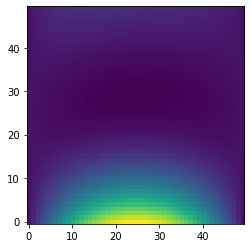

0.029750922939586116


In [84]:
### test

t_test = np.linspace(0,1,50)
x_test = np.linspace(0,1,50)

u_t = np.zeros((50,50))

error = 0
i,j= 0,0
for x_0 in x_test:
    for t_0 in t_test:
        X_0 = np.array([x_0,t_0])
        u_t[j,i] = g_trial(X_0,W_hidden, W_out, b_hidden, b_out,Sigmoid, Identity)
        error += (u_t[i,j]-u(x_0)*np.exp(-np.pi**2*t_0))**2
        j+=1
    j=0
    i+=1
plt.imshow(u_t,origin='lower')
plt.show()
error/= (np.size(t_test)*np.size(x_test))
print(error)